A Tutorial on Autoencoders
====

In this notebook, we briefly experiment with a sparse autoencoder.

## Setup

We import our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from models.autoencoder import Autoencoder

Set eager mode for `tfds`.

In [2]:
tf.compat.v1.enable_eager_execution()

We set our GPU memory growth for efficiency.

In [3]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True
)


Set the random number generator seed value.

In [4]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

We set the batch size and the number of epochs.

In [5]:
BATCH_SIZE = 64
EPOCHS = 10

## Dataset

We load the MNIST dataset.

In [6]:
train_dataset = tfds.load("mnist", split=tfds.Split.TRAIN)

We define a normalization function.

In [7]:
def normalize(example):
    features = example["image"]
    features = tf.reshape(features, [-1, 784])
    features = tf.cast(features, tf.float32)
    features = features / 255.
    return features, features

We customize our `tf.data.Dataset` pipeline.

In [8]:
train_dataset = train_dataset.map(normalize)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(BATCH_SIZE, True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Model

We define a class for the Encoder, Decoder, and the Autoencoder.

To add a sparsity constraint, we regularize the encoder output layer.

In [9]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim=128, code_dim=64):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(
            units=intermediate_dim, activation=tf.nn.relu
        )
        self.output_layer = tf.keras.layers.Dense(
            units=code_dim,
            activation=tf.nn.sigmoid,
            activity_regularizer=tf.keras.regularizers.l2(1e-2)
        )

    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)

We now define a Decoder.

In [10]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, original_dim, code_dim=64):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=code_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(
            units=original_dim, activation=tf.nn.sigmoid
        )

    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

Then, build the Autoencoder.

In [11]:
class Autoencoder(tf.keras.Model):
    def __init__(self, code_dim=64, intermediate_dim=128, original_dim=784):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(code_dim=code_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(code_dim=code_dim, original_dim=original_dim)

    def call(self, features):
        code = self.encoder(features)
        reconstructed = self.decoder(code)
        return reconstructed

Let's instantiate our Autoencoder.

In [12]:
model = Autoencoder()

Call the model once to get a summary.

In [13]:
for batch_features, _ in train_dataset.take(1):
    model(batch_features)
    break

Display the model summary.

In [14]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  108736    
_________________________________________________________________
decoder (Decoder)            multiple                  55120     
Total params: 163,856
Trainable params: 163,856
Non-trainable params: 0
_________________________________________________________________


Compile the model for training.

In [15]:
model.compile(loss=tf.losses.mean_squared_error,
              optimizer=tf.optimizers.Adam(learning_rate=1e-2))

Train the model for 10 epochs.

In [16]:
history = model.fit(train_dataset, epochs=EPOCHS, verbose=2)

Epoch 1/10
937/937 - 5s - loss: 0.0621
Epoch 2/10
937/937 - 4s - loss: 0.0257
Epoch 3/10
937/937 - 4s - loss: 0.0199
Epoch 4/10
937/937 - 4s - loss: 0.0180
Epoch 5/10
937/937 - 4s - loss: 0.0167
Epoch 6/10
937/937 - 4s - loss: 0.0157
Epoch 7/10
937/937 - 4s - loss: 0.0149
Epoch 8/10
937/937 - 4s - loss: 0.0143
Epoch 9/10
937/937 - 4s - loss: 0.0139
Epoch 10/10
937/937 - 4s - loss: 0.0136


Plot the training loss.

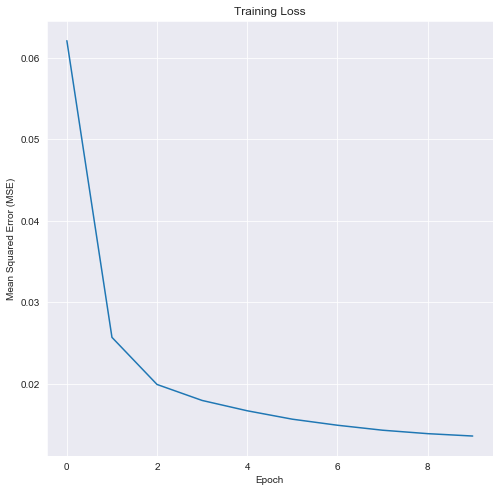

In [17]:
loss = history.history["loss"]

sns.set_style("darkgrid")

plt.figure(figsize=(8, 8))
plt.plot(loss)
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Epoch")
plt.title("Training Loss")
plt.show()

Load the test data.

In [18]:
test_dataset = tfds.load("mnist", split=tfds.Split.TEST, batch_size=-1)
test_dataset = tfds.as_numpy(test_dataset)
test_features = test_dataset["image"]
test_features = test_features.astype("float32") / 255.

Visualize the reconstruction and the original data.

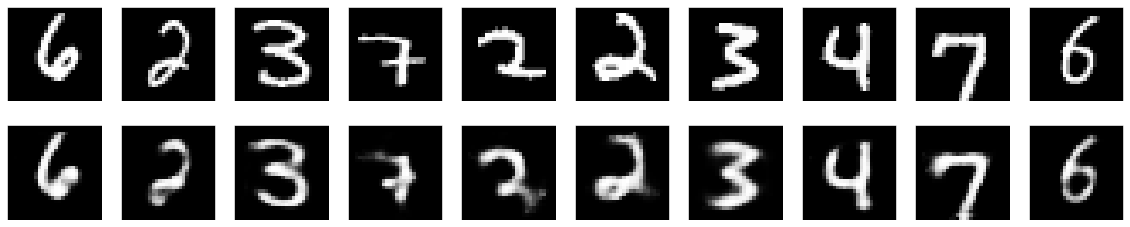

In [19]:
number = 10
plt.figure(figsize=(20, 4))

for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    test_image = test_features[index]
    test_image = test_image.reshape(28, 28)
    plt.imshow(test_image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    reconstructed = model(test_features[index].reshape(-1, 784))
    reconstructed = reconstructed.numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()